In [38]:
import numpy as np
import math

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

import matplotlib.gridspec as gridspec

import scipy
from scipy import interpolate
from scipy.sparse import diags
import scipy.sparse as sp

In [39]:
# constant variables
PI = math.pi

# define diffusion coefficient
Diff_h = 10.0 # [m2 s-1]
Diff_z = 0.15 # [m2 s-1]

# define a fixed wind field
U_shear = 0.002 # [s-1]

# initial injected concentration, can be any values here
cc = 1.0 # [kg] or [kg/s]

In [232]:
# creating plotting map/domain

# grid resolution
Dh = 10000 # [m]
Dz = 25 # [m]

Nh = 1001
Nz = 101

ih_init = round(Nh/2)
iz_init = round(Nz/2)
print('center:',ih_init,iz_init)

h = []
for ih in range(Nh):
    h.append((ih-ih_init)*Dh)
    
z = []
for iz in range(Nz):
    z.append((iz-iz_init)*Dz)

H, Z = np.meshgrid(h, z)


# *** Attention: this gaussian analytical results does NOT requires Dv=Dh
# Chris J. Walcek-A Gaussian dispersionplume model explicitly account

def CrossSection_Concnt_2D(time, Diff_h, Diff_z, U_shear, Nh, Nz, X, Y, cc):
    # time = ? [s]
    # Diff_h, Diff_z are horizontal and vertical diffusivity
    # U_shear is vertical wind shear
    # X, Y form a 2D grid/domain with grid number [Nz, Nh]
    # cc: initial injection mass

    # gaussian analytical result
    Sigma_h = math.sqrt( 2.0*Diff_h*time ) # [m]
    Sigma_z = math.sqrt( 2.0*Diff_z*time ) # [m]

    s = U_shear*time* Sigma_z/Sigma_h

    C_gau = np.zeros([Nz,Nh])

    for iz in range(Nz):
        for ih in range(Nh):
            C_gau[iz,ih] = cc/( 2*PI*Sigma_h*Sigma_z*math.sqrt(1+s**2/12) )* \
                            math.exp(-X[iz,ih]**2/(2*Sigma_h**2*(1+s**2/12)) \
                                     -Y[iz,ih]**2*(1+s**2 /3)/(2*Sigma_z**2*(1+s**2/12)) \
                                     +X[iz,ih]*Y[iz,ih]/(2*Sigma_h*Sigma_z)*(s/(1+s**2/12))
                                     )
    # Rh = Sigma_h + 2/3*math.sqrt(2.0*Diff_z)*U_shear*(time**3/2)
    # Rz = Sigma_z
    
    return C_gau

center: 500 50


In [233]:
def CrossSection_Concnt_1D(time, Diff_h, Diff_z, U_shear, xx, yy_1D, cc):
    # time = ? [s]
    # Diff_h, Diff_z are horizontal and vertical diffusivity
    # U_shear is vertical wind shear
    # X, Y form a 2D grid/domain with grid number [Nz, Nh]
    # cc: initial injection mass

    # gaussian analytical result
    Sigma_h = math.sqrt( 2.0*Diff_h*time ) # [m]
    Sigma_z = math.sqrt( 2.0*Diff_z*time ) # [m]

    s = U_shear*time* Sigma_z/Sigma_h

    Nz = len(yy_1D)
    C_1D = np.zeros([Nz])
    for iz in range(Nz):
        C_1D[iz] = cc/( 2*PI*Sigma_h*Sigma_z*math.sqrt(1+s**2/12) )* \
                        math.exp(-xx**2/(2*Sigma_h**2*(1+s**2/12)) \
                                 -yy_1D[iz]**2*(1+s**2 /3)/(2*Sigma_z**2*(1+s**2/12)) \
                                 +xx*yy_1D[iz]/(2*Sigma_h*Sigma_z)*(s/(1+s**2/12))
                                )
    
    return C_1D


def find_zz(zz_1D, concnt_1D):
    # find the zz value that corresponds to the max concnt
    
    idx = np.argmax(concnt_1D)
    zz_max = zz_1D[idx]

    return zz_max


def CrossSection_Concnt_points(time, Diff_h, Diff_z, U_shear, xx_1D, zz_1D, cc):
    # time = ? [s]
    # Diff_h, Diff_z are horizontal and vertical diffusivity
    # U_shear is vertical wind shear
    # X, Y form a 2D grid/domain with grid number [Nz, Nh]
    # cc: initial injection mass

    # gaussian analytical result
    Sigma_h = math.sqrt( 2.0*Diff_h*time ) # [m]
    Sigma_z = math.sqrt( 2.0*Diff_z*time ) # [m]

    s = U_shear*time* Sigma_z/Sigma_h

    if len(xx_1D)!=len(zz_1D): 
        print('ERROR: xx and zz do not have same size!!!')
    
    Np = len(xx_1D)
    C_1D = np.zeros([Np])
    for i in range(Np):
        C_1D[i] = cc/( 2*PI*Sigma_h*Sigma_z*math.sqrt(1+s**2/12) )* \
                        math.exp(-xx_1D[i]**2/(2*Sigma_h**2*(1+s**2/12)) \
                                 -zz_1D[i]**2*(1+s**2 /3)/(2*Sigma_z**2*(1+s**2/12)) \
                                 +xx_1D[i]*zz_1D[i]/(2*Sigma_h*Sigma_z)*(s/(1+s**2/12))
                                    )
    
    return C_1D

In [271]:
times = np.arange(24*3600,22*24*3600, 24*3600)
days = times/(24*3600)
days = days.astype(np.int32)
Nt = len(times)

Areas = []
for it in range(Nt):
    time = times[it]
    day = time/(24*3600)

    sigma_z = math.sqrt( 2.0*Diff_z*time ) # [m]
    
    # (1) identify long and short radius slope
    xx3   = 2**(day/2)*math.sqrt(2.0*Diff_z*time)
    zz3_1D = np.linspace(-10*sigma_z, 10*sigma_z, 1000)
    C3_1D = CrossSection_Concnt_1D(time, Diff_h, Diff_z, U_shear, xx3, zz3_1D, cc)*1e12
    zz3 = find_zz(zz3_1D, C3_1D)

    # xx3_max   = 0
    # zz3_1D_max = np.linspace(-1*sigma_z, 1*sigma_z, 100)
    # C3_1D_max = CrossSection_Concnt_1D(time, Diff_h, Diff_z, U_shear, xx3_max, zz3_1D_max, cc)*1e12

    i_step = 0
    while zz3<2*sigma_z: # max(C3_1D)>0.1*max(C3_1D_max) and 
        i_step = i_step + 1
        # xx3 is not far away from the center origin, so double xx3
        xx3   = (i_step*10)*2**(day/2)*math.sqrt(2.0*Diff_z*time)
        C3_1D = CrossSection_Concnt_1D(time, Diff_h, Diff_z, U_shear, xx3, zz3_1D, cc)*1e12
        zz3 = find_zz(zz3_1D, C3_1D)
        
    k_Ra = zz3/xx3 # along long radius
    k_Rb = -1/k_Ra

    print(f'k_Ra={k_Ra:.3f}, k_Rb={k_Rb:.3f}')
    
    # (2) decide the values for Ra and Rb, with concentration about 10 time smaller the center concentration
    
    # along long radius Ra:
    Xs1 = np.linspace(-2*xx3, 2*xx3, 1000)
    Zs1 = k_Ra*Xs1
    Cs1 = CrossSection_Concnt_points(time, Diff_h, Diff_z, U_shear, Xs1, Zs1, cc)*1e12
    Ra = (Xs1**2 + Zs1**2)**0.5 * (Xs1/abs(Xs1))/1000 # km

    for i in range(len(Ra)):
        if Cs1[i]>0.1*max(Cs1):
            Ra_final = abs(Ra[i-1])
            break;

    # along short radius Rb:
    Zs2 = np.linspace(-10*sigma_z, 10*sigma_z, 100)
    Xs2 = Zs2/k_Rb
    Cs2 = CrossSection_Concnt_points(time, Diff_h, Diff_z, U_shear, Xs2, Zs2, cc)*1e12
    Rb = (Xs2**2 + Zs2**2)**0.5 * (Xs2/abs(Xs2)) / 1000

    for i in range(len(Rb)):
        if Cs2[i]>0.1*max(Cs2):
            Rb_final = abs(Rb[i-1])
            break;

    area = PI*Ra_final*Rb_final
    Areas.append(area)
    print(f'When time={day} day, Ra={Ra_final:.3f}, Rb={Rb_final:.3f}, area is {area:.3f} km2')



k_Ra=0.009, k_Rb=-116.027
When time=1.0 day, Ra=34.639, Rb=0.179, area is 19.468 km2
k_Ra=0.004, k_Rb=-231.652
When time=2.0 day, Ra=97.802, Rb=0.253, area is 77.731 km2
k_Ra=0.003, k_Rb=-344.585
When time=3.0 day, Ra=179.614, Rb=0.310, area is 174.835 km2
k_Ra=0.002, k_Rb=-458.871
When time=4.0 day, Ra=276.625, Rb=0.358, area is 310.919 km2
k_Ra=0.002, k_Rb=-578.903
When time=5.0 day, Ra=386.134, Rb=0.400, area is 485.232 km2
k_Ra=0.001, k_Rb=-688.306
When time=6.0 day, Ra=508.192, Rb=0.438, area is 699.567 km2
k_Ra=0.001, k_Rb=-803.488
When time=7.0 day, Ra=641.108, Rb=0.473, area is 953.247 km2
k_Ra=0.001, k_Rb=-917.742
When time=8.0 day, Ra=782.413, Rb=0.506, area is 1243.673 km2
k_Ra=0.001, k_Rb=-1032.182
When time=9.0 day, Ra=934.257, Rb=0.537, area is 1575.116 km2
k_Ra=0.001, k_Rb=-1157.213
When time=10.0 day, Ra=1093.292, Rb=0.566, area is 1942.948 km2
k_Ra=0.001, k_Rb=-1261.663
When time=11.0 day, Ra=1262.653, Rb=0.593, area is 2353.452 km2
k_Ra=0.001, k_Rb=-1383.896
When time

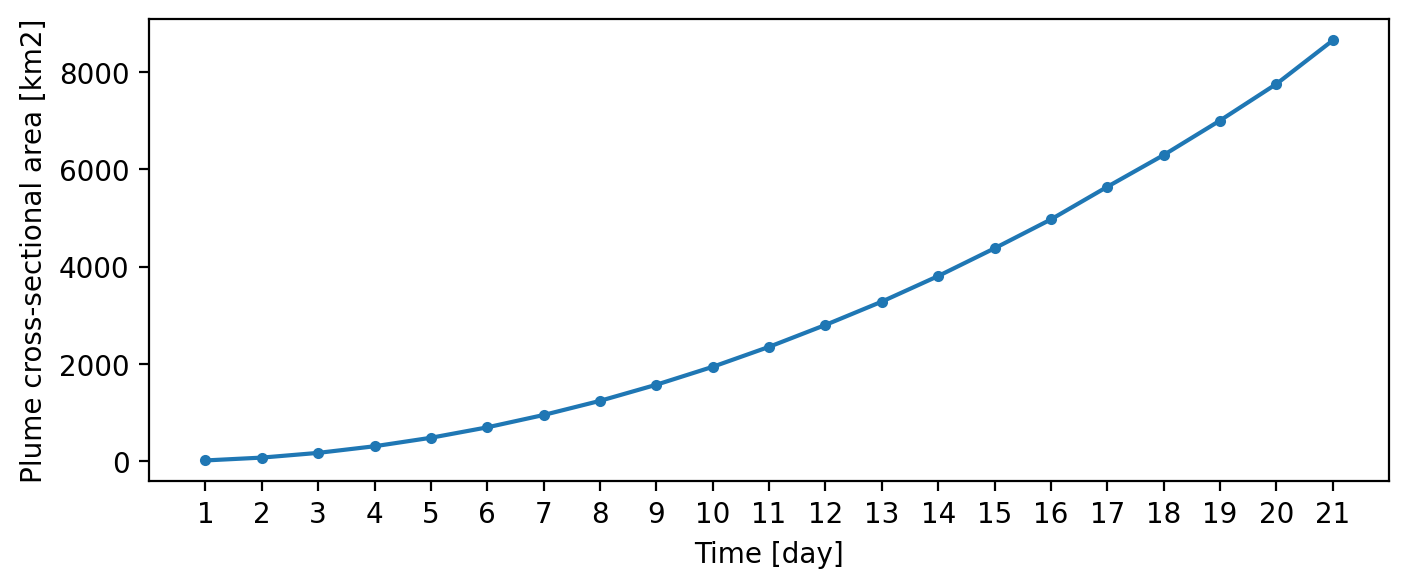

In [272]:

fig = plt.figure(figsize=(8,3), dpi=200)

plt.plot(days, Areas, '.-');
plt.xticks(days, labels=days)

plt.xlabel('Time [day]')
plt.ylabel('Plume cross-sectional area [km2]');


In [273]:
import pandas as pd

In [274]:
d = {'Day': days, 'Area [km2]': Areas}
df = pd.DataFrame(data=d)
df.to_csv('Time_series_of_CrossSection_Area.csv', index=False) 

In [275]:
df

,Day,Area [km2]
0,1,19.467517
1,2,77.730904
2,3,174.834920
3,4,310.919298
4,5,485.231508
5,6,699.566574
6,7,953.247227
7,8,1243.672761
8,9,1575.116353
9,10,1942.948013


In [276]:
time

1814400

In [277]:
21*24*3600

1814400

In [ ]:
fig = plt.figure(figsize=(18,6), dpi=200)

gs = gridspec.GridSpec(24, 24, figure=fig)

### 21 day
time1 = time # [s]
C1_gau = CrossSection_Concnt_2D(time1, Diff_h, Diff_z, U_shear, Nh, Nz, H, Z, cc)

# plot
ax1 = fig.add_subplot(gs[0:11, 0:17])
# ax1 = plt.subplot(3,1,1)
# levs = np.arange(0.5,4.0,0.5)*1e-8 * 1e12
# ax1_contours = ax1.contourf(H[5:-5,5:-5]/1000, Z[5:-5,5:-5]/1000, C1_gau[5:-5,5:-5] *1e12, \
                        # cmap='Reds')
ax1_contours = ax1.contourf(H/1000, Z/1000, C1_gau*1e12, \
                        cmap='Reds')

ax1_point = ax1.plot([-xx3/1000,xx3/1000], [-k_Ra*xx3/1000,k_Ra*xx3/1000], 'y--', label='Ra')
# ax1_point = ax1.plot([-k_Ra*xx3/1000,k_Ra*xx3/1000], [xx3/1000,-xx3/1000], 'b--')
value = 1.5
scale = 6 # only for plotting!!!
ax1_point = ax1.plot([value/k_Ra/scale,-value/k_Ra/scale], [-value,value], 'b--', label='Rb')


# cbar1 = plt.colorbar(ax1_contours, ax=ax1)
# cbar1.ax.set_ylabel('$ng \cdot m^{-2}$',fontsize=12)
# cbar1.ax.tick_params(labelsize=12)

ax1.set_title('(a)',fontsize=14,loc='left')
ax1.set_title('2-D concentration distribution on Day 21',fontsize=14)

ax1.set_xlim([-1.3*Ra_final,1.3*Ra_final])
ax1.set_ylim([-1.3*Rb_final,1.3*Rb_final])

ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)

ax1.set_xlabel('Horizontal distance [km]',fontsize=12);
ax1.set_ylabel('Vertical distance [km]',fontsize=12);

ax1.legend();

### (2)
ax2 = fig.add_subplot(gs[0:11, 19:24])

Zs2 = np.linspace(-1.3*Rb_final*1000, 1.3*Rb_final*1000, 100)
Xs2 = Zs2/k_Rb
Cs2 = CrossSection_Concnt_points(time, Diff_h, Diff_z, U_shear, Xs2, Zs2, cc)*1e12
Rb = (Xs2**2 + Zs2**2)**0.5 * (Xs2/abs(Xs2)) / 1000

ax2.plot(Cs2, Rb, 'b--')
ax2.axhline(y = -Rb_final, color = 'k', linestyle = '-') 
ax2.axhline(y = Rb_final, color = 'k', linestyle = '-', label=f'Selected Rb={Rb_final:.1f} km')

ax2.set_title('(b)',fontsize=14,loc='left')
ax2.set_title('Along short radius (Rb)',fontsize=14)

ax2.set_xlim([0,300])
ax2.set_ylim([-1.3*Rb_final,1.3*Rb_final])

ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)

ax2.set_ylabel('Rb [km]',fontsize=12);
ax2.set_xlabel('1D Concentration [mg/m2]',fontsize=12);

ax2.legend();

###
ax3 = fig.add_subplot(gs[16:24, 0:17])

Xs1 = np.linspace(-1.3*Ra_final*1000, 1.3*Ra_final*1000, 100)
Zs1 = k_Ra*Xs1
Cs1 = CrossSection_Concnt_points(time, Diff_h, Diff_z, U_shear, Xs1, Zs1, cc)*1e12
Ra = (Xs1**2 + Zs1**2)**0.5 * (Xs1/abs(Xs1))/1000 # km

ax3.plot(Ra, Cs1, 'y--')
ax3.axvline(x = -Ra_final, color = 'k', linestyle = '-') 
ax3.axvline(x = Ra_final, color = 'k', linestyle = '-', label=f'Selected Ra={Ra_final:.0f} km')

ax3.set_title('(c)',fontsize=14,loc='left')
ax3.set_title('1-D concentration along long radius (Ra)',fontsize=14)

ax3.set_xlim([-1.3*Ra_final,1.3*Ra_final])
ax3.set_ylim([0,300])

ax3.tick_params(axis='x', labelsize=12)
ax3.tick_params(axis='y', labelsize=12)

ax3.set_xlabel('Horizontal distance [km]',fontsize=12);
ax3.set_ylabel('[mg/m2]',fontsize=12);

ax3.legend();

# fig.tight_layout();

In [242]:
1, 1/k_Ra

(1, 2415.202893459398)

In [248]:
k_Rb

-2415.202893459398

In [249]:
k_Ra

0.0004140438895250151